# 파이토치 MNIST 모델

## modules import 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

## 전처리 설정
- `transform.Compose`

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])


## 데이터 로드 및 데이터 확인

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [26]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [5]:
image, label = next(iter(train_loader))

In [6]:
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [7]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

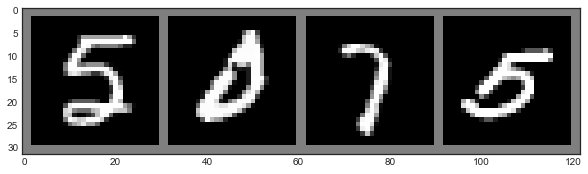

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))

## 신경망 구성

In [9]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)           # 6*6 의 의미? 아니고 5*5로 해야 됨 왜??? : 28*28에서 3*3 conv. 2번, 2*2 maxpool 2번 하고나면 5*5 됨
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        # print("x__size :", x.size())                  # batch size 가 첫번째 element인지 확인
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]                             # 왜 size()[0]은 제외함? batch size가 들어가는 자리라서.
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- `.parameters()` 

In [10]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


임의의 값을 넣어 forward값 확인

In [11]:
input = torch.randn(128, 1, 28, 28)
out = net(input)
print(out)

tensor([[-0.0195, -0.0678,  0.0091,  ..., -0.0168,  0.0805,  0.1032],
        [-0.0367, -0.0549, -0.0110,  ..., -0.0341,  0.0812,  0.1055],
        [-0.0432, -0.0621,  0.0254,  ..., -0.0335,  0.0616,  0.1041],
        ...,
        [-0.0294, -0.0695,  0.0049,  ..., -0.0431,  0.0676,  0.1035],
        [-0.0260, -0.0597, -0.0087,  ..., -0.0180,  0.0751,  0.1113],
        [-0.0228, -0.0516, -0.0131,  ..., -0.0402,  0.0901,  0.1116]],
       grad_fn=<AddmmBackward0>)


## 손실함수와 옵티마이저

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

- `optimizer.zero_grad` : 가중치의 그래디언트 초기화

- loss 계산

- `loss.backward()`

- `optmizer.step()` : 업데이트

- 배치수 확인

In [13]:
total_batch = len(train_loader)
print(total_batch)                  # 위에서 train_loader 정의할 때 batch_size 128로 정했는데 왜 469..? 128은 미니배치 사이즈, 469는 전체 example 수 (bath)

469


- 설명을 위해 `epochs=2`로 지정

In [14]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):     # 0은 시작 인덱스를 말함. i=0부터 시작함.
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % 100 == 99:
            print("Epoch: {}, Iter: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11518124127388
Epoch: 1, Iter: 200, Loss: 0.1147149807214737
Epoch: 1, Iter: 300, Loss: 0.1140478583574295
Epoch: 1, Iter: 400, Loss: 0.11314287006855012
Epoch: 2, Iter: 100, Loss: 0.10887861621379852
Epoch: 2, Iter: 200, Loss: 0.1005274812579155
Epoch: 2, Iter: 300, Loss: 0.07661014294624328
Epoch: 2, Iter: 400, Loss: 0.045267235040664676


## 모델의 저장 및 로드

- `torch.save`
  - `net.state_dict()`를 저장

- `torch.load`
  - `load_state_dict`로 모델을 로드

In [15]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

## 모델 테스트

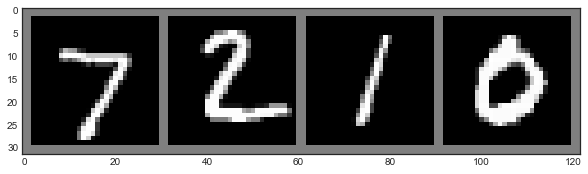

In [31]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

In [38]:
outputs = net(images)
outputs.size()
outputs
outputs.data

tensor([[ -5.6893,   7.1650,   0.8079,   1.8579,  -2.9737,  -1.1620,  -2.6546,
           1.4587,   1.7838,   0.3519],
        [ -1.3924,  -0.3825,   3.3814,   4.4281,  -7.4068,   1.1047,  -2.9465,
           1.2874,   2.8479,  -1.6742],
        [ -2.4682,  -0.4053,   0.9340,   4.7524,  -6.1174,   2.4457,  -3.0073,
           1.6894,   3.3466,  -0.4140],
        [ -4.2459,  -3.0302,  -5.5670,  -3.0090,   7.3263,   1.2486,   0.2402,
           0.4582,   2.7057,   5.5265],
        [  0.2417,  -2.6572,  -1.3350,   1.8118,  -2.6646,   3.9742,  -1.3754,
          -0.6585,   3.3303,   0.1624],
        [  1.5329,  -4.9271,   3.3617,  -0.7224,   0.4171,   2.9377,   7.0382,
          -9.7641,   2.7256,  -2.8290],
        [ -4.7005,   2.4756,  -2.0476,   2.9543,  -4.1274,  -0.3778,  -7.1618,
           7.5853,   2.7623,   3.2967],
        [  0.5588,  -3.9713,   1.2244,   4.6552,  -5.7053,   3.8644,  -1.9616,
          -1.3351,   4.4690,  -0.9442],
        [ -1.3184,  -5.2578,  -3.9439,  -2.1921,

In [33]:
_, predicted = torch.max(outputs, 1)  # 동일 1순위 값이 있을 때 앞에 있는 index를 출력
print(predicted)

tensor([7, 2, 1, 0, 4, 1, 9, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 7, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 9, 2, 3, 5, 3, 2,
        9, 4, 6, 3, 5, 5, 6, 5, 4, 1, 9, 8, 7, 8, 4, 3, 7, 4, 2, 4, 3, 0, 7, 0,
        2, 7, 1, 7, 3, 7, 9, 7, 7, 6, 2, 7, 4, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 1, 3, 9, 1, 4, 4, 4, 4, 8,
        5, 4, 7, 6, 9, 9, 3, 5])


In [34]:
print(''.join('{}\t'.format(str(predicted[j].numpy())) for j in range(4)))

7	2	1	0	


In [44]:
# accuracy 계산

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)   # mini batch size (128) 더함
        correct += (predicted == labels).sum().item()

print(100 * correct / total) 

82.08


## GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 형태로 변환 해줘야 한다.

- `.cuda()` 로도 가능

- 현재 GPU 설정

- 데이터 로드


- 모델 생성